# Задание 1.1 - Метод К-ближайших соседей (K-neariest neighbor classifier)

В первом задании вы реализуете один из простейших алгоритмов машинного обучения - классификатор на основе метода K-ближайших соседей.
Мы применим его к задачам
- бинарной классификации (то есть, только двум классам)
- многоклассовой классификации (то есть, нескольким классам)

Так как методу необходим гиперпараметр (hyperparameter) - количество соседей, мы выберем его на основе кросс-валидации (cross-validation).

Наша основная задача - научиться пользоваться numpy и представлять вычисления в векторном виде, а также ознакомиться с основными метриками, важными для задачи классификации.

Перед выполнением задания:
- запустите файл `download_data.sh`, чтобы скачать данные, которые мы будем использовать для тренировки
- установите все необходимые библиотеки, запустив `pip install -r requirements.txt` (если раньше не работали с `pip`, вам сюда - https://pip.pypa.io/en/stable/quickstart/)

Если вы раньше не работали с numpy, вам может помочь tutorial. Например этот:  
http://cs231n.github.io/python-numpy-tutorial/

In [2]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [3]:
from dataset import load_svhn
from knn import KNN
from metrics import binary_classification_metrics, multiclass_accuracy

# Загрузим и визуализируем данные

В задании уже дана функция `load_svhn`, загружающая данные с диска. Она возвращает данные для тренировки и для тестирования как numpy arrays.

Мы будем использовать цифры из датасета Street View House Numbers (SVHN, http://ufldl.stanford.edu/housenumbers/), чтобы решать задачу хоть сколько-нибудь сложнее MNIST.

In [3]:
train_X, train_y, test_X, test_y = load_svhn("data", max_train=1000, max_test=100)

In [ ]:
samples_per_class = 5  # Количество изображений каждого класса для отрисовки
plot_index = 1
for example_index in range(samples_per_class):
    for class_index in range(10):
        plt.subplot(5, 10, plot_index)
        image = train_X[train_y == class_index][example_index]
        plt.imshow(image.astype(np.uint8))
        plt.axis('off')
        plot_index += 1

# Сначала реализуем KNN для бинарной классификации

В качестве задачи бинарной классификации мы натренируем модель, которая будет отличать цифру 0 от цифры 9.

In [5]:
binary_train_mask = (train_y == 0) | (train_y == 9)
binary_train_y = train_y[binary_train_mask]
print(binary_train_y)

[0 0 0 0 0 9 0 9 0 9 0 9 0 9 0 9 0 0 0 9 0 9 0 0 0 0 9 9 9 0 0 0 9 9 0 0 9
 0 9 0 0 9 0 0 0 0 0 0 9 0 0 9 9 0 9 0 9 9 9 0 0 9 9 9 9 9 9 9 9 0 9 9 9 9
 0 9 9 0 0 0 0 0 0 9 0 9 0 9 9 9 0 9 0 9 0 9 9 0 0 9 0 9 0 9 0 0 9 0 9 0 9
 9 9 0 9 0 0 0 0 0 0]


In [6]:
# Для начала подготовим изображения цифр и к какому классу они принадлежат

# Выберем только нули и девятки
binary_train_mask = (train_y == 0) | (train_y == 9)
binary_train_X = train_X[binary_train_mask]
binary_train_y = train_y[binary_train_mask] == 0    #массив train true-0 и false-9

binary_test_mask = (test_y == 0) | (test_y == 9)
binary_test_X = test_X[binary_test_mask]
binary_test_y = test_y[binary_test_mask] == 0       #массив test true-0 и false-9

# Используем функцию reshape для приведения каждого изображения к одномерному массиву [num_samples, 32*32*3]
binary_train_X = binary_train_X.reshape(binary_train_X.shape[0], -1)
binary_test_X = binary_test_X.reshape(binary_test_X.shape[0], -1)

In [23]:
# Создадим классификатор и вызовем функцию fit для обучения модели
# KNN запомнит все данные
knn_classifier = KNN()
knn_classifier.fit(binary_train_X, binary_train_y)

Последовательно реализуем функции `compute_distances_two_loops`, `compute_distances_one_loop` и `compute_distances_no_loops`
в файле `knn.py`.

Эти функции строят массив расстояний между всеми векторами в тестовом наборе и в тренировочном наборе.  
В результате они должны построить массив размера `(num_test, num_train)`, где координата `[i][j]` соотвествует расстоянию между i-м вектором в test (`test[i]`) и j-м вектором в train (`train[j]`).

**Обратите внимание** Для простоты реализации мы будем использовать в качестве расстояния меру L1 (ее еще называют [Manhattan distance](https://ru.wikipedia.org/wiki/%D0%A0%D0%B0%D1%81%D1%81%D1%82%D0%BE%D1%8F%D0%BD%D0%B8%D0%B5_%D0%B3%D0%BE%D1%80%D0%BE%D0%B4%D1%81%D0%BA%D0%B8%D1%85_%D0%BA%D0%B2%D0%B0%D1%80%D1%82%D0%B0%D0%BB%D0%BE%D0%B2)).

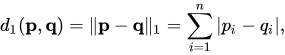

In [24]:
# Посчитаем растояния при помощи функции compute_distances_two_loops в knn.py
dists = knn_classifier.compute_distances_two_loops(binary_test_X)
assert np.isclose(dists[0, 10], np.sum(np.abs(binary_test_X[0] - binary_train_X[10])))

In [ ]:
# TODO: Дополнительное задание - реализуйте функцию compute_distances_one_loop в knn.py
dists = knn_classifier.compute_distances_one_loop(binary_test_X)
assert np.isclose(dists[0, 10], np.sum(np.abs(binary_test_X[0] - binary_train_X[10])))

In [ ]:
# TODO: Дополнительное задание - реализуйте функцию compute_distances_no_loops в knn.py
dists = knn_classifier.compute_distances_no_loops(binary_test_X)
assert np.isclose(dists[0, 10], np.sum(np.abs(binary_test_X[0] - binary_train_X[10])))


In [ ]:
# Дополнительное задание - сравните время вычислений с циклами и без.
%timeit knn_classifier.compute_distances_two_loops(binary_test_X)
%timeit knn_classifier.compute_distances_one_loop(binary_test_X)
%timeit knn_classifier.compute_distances_no_loops(binary_test_X)

In [25]:
# Сделаем предсказание при помощи функции predict_labels_binary в knn.py
prediction = knn_classifier.predict(binary_test_X)
print(prediction)

[ True False False False  True False False  True False False False  True
 False False False False]


In [12]:
# Найдем метрики предсказания при помощи функции binary_classification_metrics в metrics.py
precision, recall, f1, accuracy = binary_classification_metrics(prediction, binary_test_y)
print("KNN with k = %s" % knn_classifier.k)
print("Accuracy: %4.2f, Precision: %4.2f, Recall: %4.2f, F1: %4.2f" % (accuracy, precision, recall, f1)) 

KNN with k = 1
Accuracy: 0.25, Precision: 0.50, Recall: 0.17, F1: 0.25


In [13]:
# Проверим работу реализованых функций для K = 3
knn_classifier_3 = KNN(k=5)
knn_classifier_3.fit(binary_train_X, binary_train_y)
prediction = knn_classifier_3.predict(binary_test_X, 2)

precision, recall, f1, accuracy = binary_classification_metrics(prediction, binary_test_y)
print("KNN with k = %s" % knn_classifier_3.k)
print("Accuracy: %4.2f, Precision: %4.2f, Recall: %4.2f, F1: %4.2f" % (accuracy, precision, recall, f1)) 

KNN with k = 5
Accuracy: 0.50, Precision: 0.75, Recall: 0.50, F1: 0.60


# Кросс-валидация (cross-validation)

Попробуем найти лучшее значение параметра k для алгоритма KNN! 

Для этого мы воспользуемся k-fold cross-validation (https://en.wikipedia.org/wiki/Cross-validation_(statistics)#k-fold_cross-validation). Мы разделим тренировочные данные на 5 фолдов (folds), и по очереди будем использовать каждый из них в качестве проверочных данных (validation data), а остальные -- в качестве тренировочных (training data).

В качестве финальной оценки эффективности k мы усредним значения F1 score на всех фолдах.
После этого мы просто выберем значение k с лучшим значением метрики.

*Бонус*: есть ли другие варианты агрегировать F1 score по всем фолдам? Напишите плюсы и минусы в клетке ниже.

In [14]:
# Найдем лучшее k используя кросс-валидацию на основе метрики F1
num_folds = 5
train_folds_X = []
train_folds_y = []

# Разделим тренировочные данные на 5 фолдов и сохраним их в train_folds_X/train_folds_y
trunc_binary_train_X = binary_train_X[0 : (np.size(binary_train_X, axis=0) - np.size(binary_train_X, axis=0) % 5), :]
trunc_binary_train_y = binary_train_y[0 : (np.size(binary_train_y, axis=0) - np.size(binary_train_y, axis=0) % 5)]
train_folds_X = np.stack(np.array_split(trunc_binary_train_X, num_folds))
train_folds_y = np.stack(np.array_split(trunc_binary_train_y, num_folds))

k_choices = [1, 2, 3, 5, 8, 10, 15, 20, 25, 50]
k_to_f1 = {}  # словарь, объединяющий значения k и соответствующие средние значения F1 (int -> float)
average_f1 = 0
for k in k_choices:
    # Выполним кросс-валидацию
    # Пройдем через каждый из фолдов и используем их для тестирования, а все остальные для валидации
    # Выполним обучение и определим метрику F1 на фолде для валидации
    # Усредним метрику F1 и запишем ее в k_to_f1
    knn_classifier_cross = KNN(k=k)
    for l in range(num_folds):
        knn_classifier_cross.fit(np.concatenate(np.delete(train_folds_X, l, axis=0)), np.concatenate(np.delete(train_folds_y, l, axis=0)))
        prediction = knn_classifier_cross.predict(train_folds_X[l,:,:])
        precision, recall, f1, accuracy = binary_classification_metrics(prediction, train_folds_y[l,:])
        average_f1 += f1 
    k_to_f1[k] = average_f1 / num_folds
    average_f1 = 0

for k in sorted(k_to_f1):
    print('k = %d, f1 = %f' % (k, k_to_f1[k]))

k = 1, f1 = 0.280381
k = 2, f1 = 0.530060
k = 3, f1 = 0.213835
k = 5, f1 = 0.509342
k = 8, f1 = 0.637960
k = 10, f1 = 0.666404
k = 15, f1 = 0.508034
k = 20, f1 = 0.636780
k = 25, f1 = 0.620357
k = 50, f1 = 0.606564


### Проверим, как хорошо работает лучшее значение k на тестовых данных (test data)

In [15]:
# TODO: Установите лучший k, найденный при кросс-валидации
best_k = 10

best_knn_classifier = KNN(k=best_k)
best_knn_classifier.fit(binary_train_X, binary_train_y)
prediction = best_knn_classifier.predict(binary_test_X)

precision, recall, f1, accuracy = binary_classification_metrics(prediction, binary_test_y)
print("Best KNN with k = %s" % best_k)
print("Accuracy: %4.2f, Precision: %4.2f, Recall: %4.2f, F1: %4.2f" % (accuracy, precision, recall, f1)) 

Best KNN with k = 10
Accuracy: 0.75, Precision: 0.75, Recall: 1.00, F1: 0.86


# Многоклассовая классификация (multi-class classification)

Переходим к следующему этапу - классификации на каждую цифру.

In [43]:
##########################################################################################
train_X, train_y, test_X, test_y = load_svhn("data", max_train=1000, max_test=100)

In [44]:
# Теперь будем использовать все 10 классов
train_X = train_X.reshape(train_X.shape[0], -1)
test_X = test_X.reshape(test_X.shape[0], -1)

knn_classifier = KNN(8)
knn_classifier.fit(train_X, train_y)

In [45]:
# TODO: Реализуйте функцию predict_labels_multiclass
prediction = knn_classifier.predict(test_X)
print("prediction = ", list(prediction))
print("test_y =     ", list(test_y))
print(sum(prediction == test_y) / len(test_y))
'''
ground_truth = test_y
tp = list(map(int, np.logical_and((0 == ground_truth), (0 == prediction))))
tn = list(map(int, (np.logical_xor((ground_truth == prediction), np.logical_and((0 == ground_truth), (0 == prediction))))))
fp = list(map(int, (np.logical_and((0 != ground_truth), (0 == prediction)))))
fn = list(map(int, (np.logical_and((0 == ground_truth), (0 != prediction)))))
print("tp(0) =      ", tp)
print("tn(0) =      ", tn)
print("fp(0) =      ", fp)
print("fp(0) =      ", fn)
'''

prediction =  [2, 1, 5, 0, 4]
test_y =      [2, 1, 3, 0, 2]
0.6


'\nground_truth = test_y\ntp = list(map(int, np.logical_and((0 == ground_truth), (0 == prediction))))\ntn = list(map(int, (np.logical_xor((ground_truth == prediction), np.logical_and((0 == ground_truth), (0 == prediction))))))\nfp = list(map(int, (np.logical_and((0 != ground_truth), (0 == prediction)))))\nfn = list(map(int, (np.logical_and((0 == ground_truth), (0 != prediction)))))\nprint("tp(0) =      ", tp)\nprint("tn(0) =      ", tn)\nprint("fp(0) =      ", fp)\nprint("fp(0) =      ", fn)\n'

In [46]:
# TODO: Реализуйте функцию multiclass_accuracy
accuracy = multiclass_accuracy(prediction, test_y)
print("Accuracy: %4.2f" % accuracy)

Accuracy: 0.94


Снова кросс-валидация. Теперь нашей основной метрикой стала точность (accuracy), и ее мы тоже будем усреднять по всем фолдам.

In [ ]:
# Найдите лучшее k используя кросс-валидацию основанную на точности (accuracy)
num_folds = 5
train_folds_X = []
train_folds_y = []

# TODO: разделите тренировочные данные на 5 фолдов и сохраните их в train_folds_X/train_folds_y
trunc_train_X = train_X[0 : (np.size(train_X, axis=0) - np.size(train_X, axis=0) % 5), :]
trunc_train_y = train_y[0 : (np.size(train_y, axis=0) - np.size(train_y, axis=0) % 5)]
train_folds_X = np.stack(np.array_split(trunc_train_X, num_folds))
train_folds_y = np.stack(np.array_split(trunc_train_y, num_folds))

k_choices = [1, 2, 3, 5, 8, 10, 15, 20, 25, 50]
k_to_accuracy = {}
average_accuracy = 0
for k in k_choices:
    # TODO: проведите кросс-валидацию
    # Пройдите через каждый из фолдов и используйте их для тестирования, а все остальные для валидации
    # Выполните обучение и определите точность (accuracy) на фолде для валидации
    # Усредните точность (accuracy) по всем фолдам и запишите в k_to_accuracy
    knn_classifier_cross = KNN(k=k)
    for l in range(num_folds):
        knn_classifier_cross.fit(np.concatenate(np.delete(train_folds_X, l, axis=0)), np.concatenate(np.delete(train_folds_y, l, axis=0)))
        prediction = knn_classifier_cross.predict(train_folds_X[l,:,:])
        accuracy = multiclass_accuracy(prediction, train_folds_y[l,:])
        average_accuracy += accuracy 
    k_to_accuracy[k] = average_accuracy / num_folds
    average_accuracy = 0

for k in sorted(k_to_accuracy):
    print('k = %d, accuracy = %f' % (k, k_to_accuracy[k]))

### Финальный тест - классификация на 10 классов на тестовой выборке (test data)

Если все реализовано правильно, вы должны увидеть точность не менее **0.2**.

In [ ]:
# TODO Установите лучший k из вычисленных при кросс-валидации
best_k = 1

best_knn_classifier = KNN(k=best_k)
best_knn_classifier.fit(train_X, train_y)
prediction = best_knn_classifier.predict(test_X)

# Accuracy должна быль не менее 20%!
accuracy = multiclass_accuracy(prediction, test_y)
print("Accuracy: %4.2f" % accuracy)